# Parametric Poisson equation 

This notebook implements Poisson equation where diffusivity is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
Consider a two dimensional domain $\Omega = (0, 1) \times (0, 1) \subset \mathbb{R}^2$ and suppose $u: \Omega \to \mathbf{R}$ denotes the temperature field. The differential equation for temperature field is given by:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \left( m(x) \nabla u(x) \right) &= f(x)\,, \qquad &\forall x \in D_u\,, \\
        u(x) &= 0\,, \qquad &\forall x \in \Gamma_{u_d}\,, \\
        m(x) \nabla u(x)\cdot n(x) &= q(x)\,, \qquad & \forall x \in \Gamma_{u_n}\,,
    \end{aligned}
\end{equation}
where $\Gamma_{u_d}:= \left\{ x \in \partial D_u: x_1 < L_1 \right\}$ (i.e., all sides except the right side of the rectangular domain) and $\Gamma_{u_n}:= \partial D_u - \Gamma_{u_d}$. We let
\begin{equation}\tag{2}
    f(x) = 1000 (1-x_2)x_2(1 - x_1)^2 \qquad \text{and} \qquad q(x) = 50\sin(5\pi x_2)\,.
\end{equation}

The probability distribution for $m$ is given by
\begin{equation}\tag{3}
    m = \alpha_m * \exp(w) + \beta_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
where $N(0, C)$ denotes the Gaussian measure with the mean function being zero in $L^2(\Omega, \mathbb{R})$ and $C: L^2(\Omega; \mathbb{R}) \times L^2(\Omega; \mathbb{R})\to \mathbb{R}$ is a covariance operator such that $C = L_\Delta^{-2}$, where
\begin{equation}\tag{4}
    L_\Delta := \begin{cases}
        -\mathsf{a}_c \nabla \cdot \mathsf{b}_c \nabla + \mathsf{c}_c\,, \qquad\qquad  &  \text{in } D_w\,,\\
        \gamma n \cdot \mathsf{b}_c \nabla\,, \qquad \qquad & \text{on }\partial D_w\,,
    \end{cases}
\end{equation}
with $\mathsf{a}_c, \mathsf{b}_c, \mathsf{c}_c$ are the parameters and there values including $\alpha_m$ and $\beta_m$ are fixed to
\begin{equation}\tag{5}
\mathsf{a}_c = 0.005\,, \quad \mathsf{b}_c = 1\,, \quad \mathsf{c}_c = 0.2\,,\quad \alpha_m = 1\,, \quad \beta_m = 0\,.
\end{equation}

Given $m\in M$, we let $F(m) = u\in U$ be the solution of boundary value problem (BVP) Eq (1), i.e., $F: M \to U$ is the solution/forward operator. 

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/Poisson_sample_plots.png" width="600"> </p>

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import *
from plot_mix_collection import *
from plot_svd import plot_s_vec_values

sys.path.append(src_path + 'pde/')
from meshUtilities import get_dirichlet_bc, get_grid_dirichlet_bc

sys.path.append(src_path + 'prior/')
from priorSampler import PriorSampler

from poissonModel import PoissonModel

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create PoissonModel and test prior

In [3]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 1
prior_logn_translate = 0.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'Poisson'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = Vm

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

# create model
model = PoissonModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


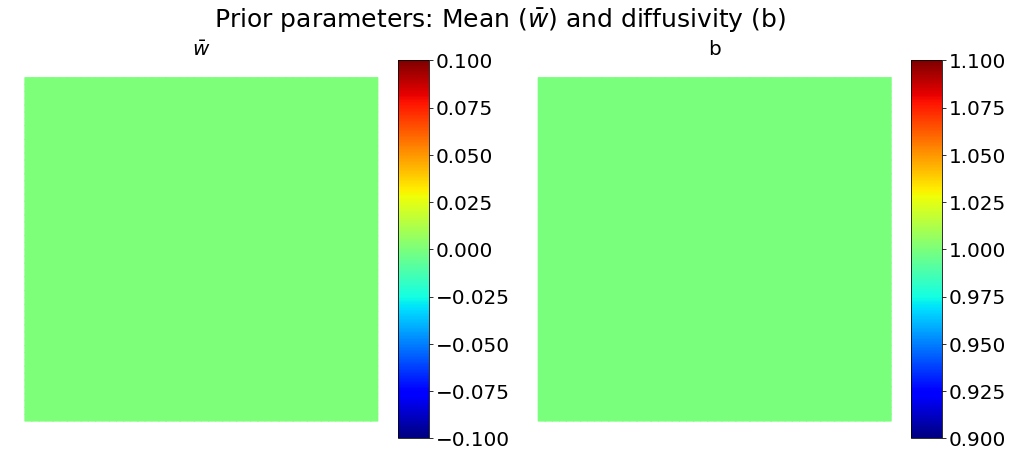

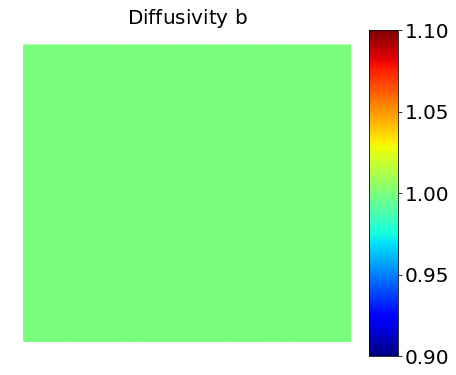

In [4]:
fs = 20
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 6))
axs = np.array([axs]) if rows == 1 else axs
stats = []
m = prior_sampler.empty_sample()

for i in range(rows):
    for j in range(cols):
        
        m = prior_sampler.mean if j == 0 else prior_sampler.function_to_vertex(prior_sampler.b_fn, None)
        # plot
        cbar = field_plot(axs[i,j], \
                  m, \
                  prior_sampler.V.mesh().coordinates(), cmap = 'jet')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[i,j].set_title(r'$\bar{w}$' if j == 0 else r'$\mathsf{b}$', fontsize=fs)
        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle(r'Prior parameters: Mean ($\bar{w}$) and diffusivity ($\mathsf{b}$)', fontsize=1.25*fs, y = 1.05)
plt.savefig(results_dir + 'prior_parameters.png',  bbox_inches='tight')
plt.show()

quick_field_plot(prior_sampler.function_to_vertex(prior_sampler.b_fn, None), prior_sampler.V.mesh().coordinates(), title = r'Diffusivity $\mathsf{b}$', cmap ='jet', figsize=(7, 6), fs = 20, savefilename=results_dir + 'prior_b.png')

Statistics of all samples
Mean: min = -4.92e-01, max = 4.75e-01, mean = -8.14e-03, std = 1.85e-01, log_prior = -7.01e-01


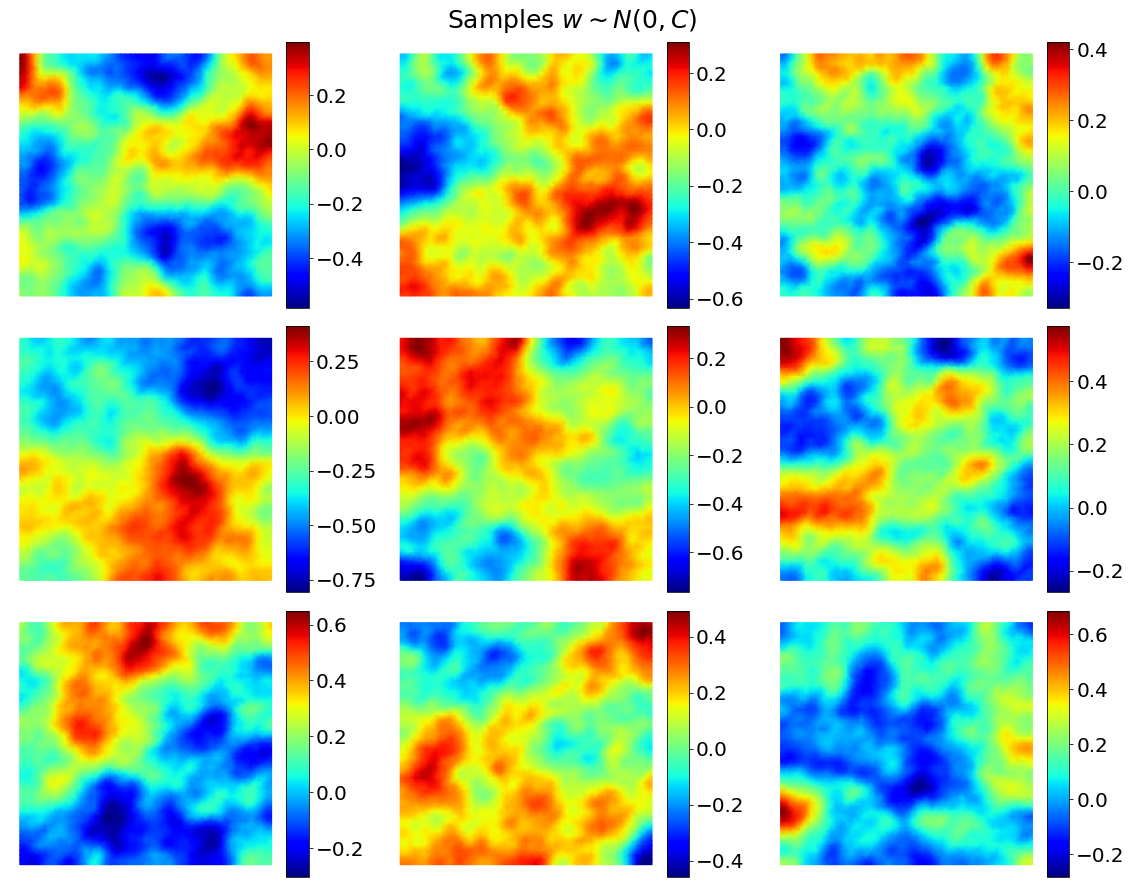

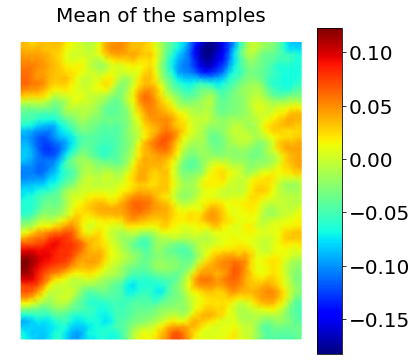

CPU times: user 5.74 s, sys: 1.9 s, total: 7.64 s
Wall time: 1.2 s


In [5]:
%%time 

fs = 20
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(16, 12))
stats = []
mvec = []
print_info = False
m = model.prior_sampler.empty_sample()
for i in range(rows):
    for j in range(cols):
        # draw a sample
        m, log_prior = model.prior_sampler(m)

        mvec.append(m)
        stats.append([np.min(m), np.max(m), np.mean(m), np.std(m), log_prior])
        if print_info:
            print('Sample: {:2d}, log_prior = {:.2e}, min = {:.2e}, max = {:.2e}, mean = {:.2e}, std = {:.2e}'.format(i*cols + j, log_prior, np.min(m), np.max(m), np.mean(m), np.std(m)))

        # plot
        cbar = field_plot(axs[i,j], \
                  m, \
                  model.m_nodes, cmap = 'jet')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        axs[i,j].axis('off')

# satistics
stats = np.array(stats)
print('Statistics of all samples')
print('Mean: min = {:.2e}, max = {:.2e}, mean = {:.2e}, std = {:.2e}, log_prior = {:.2e}'.format(np.mean(stats[:,0]), np.mean(stats[:,1]), np.mean(stats[:,2]), np.mean(stats[:,3]), np.mean(stats[:,4])))

fig.tight_layout()
fig.suptitle(r'Samples $w\sim N(0,C)$', fontsize=1.25*fs, y = 1.025)
plt.savefig(results_dir + 'prior_samples.png',  bbox_inches='tight')
plt.show()

# compute mean sample field
mvec = np.array(mvec)
m = np.mean(mvec, axis=0)
quick_field_plot(m, model.m_nodes, title='Mean of the samples', cmap ='jet')


# Test Poisson model

## Generate few samples of diffusivity and solve the forward problem

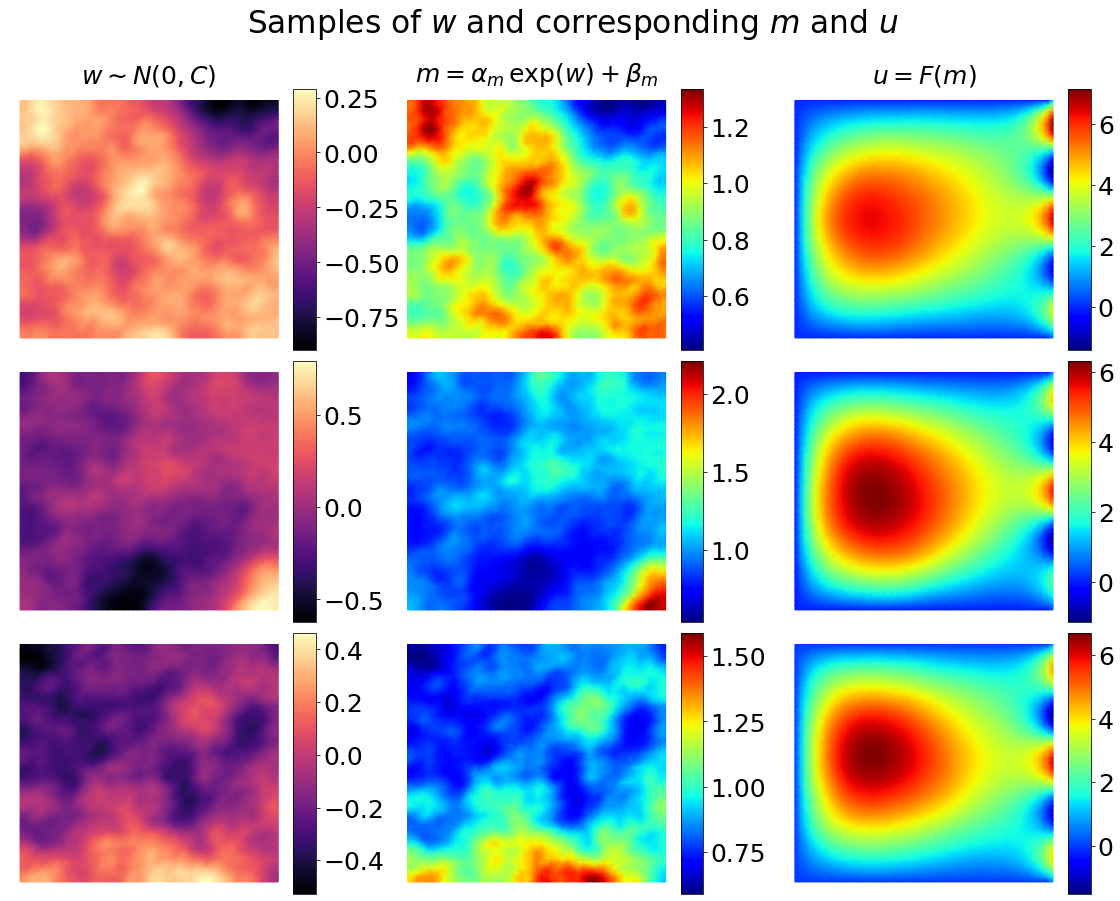

In [6]:
n_test_samples = 3

u_vec = []
title_vec = []
cmapvec = []
for i in range(n_test_samples): 
    cmapvec.append(['magma', 'jet', 'jet'])
    if i == 0:
        title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
    else:
        title_vec.append([None, None, None])

w = model.empty_m()
m = model.empty_m()
u = model.empty_u()

for i in range(n_test_samples):

    # draw a sample
    w, log_prior = model.prior_sampler(w)

    # transform w to m
    m = model.transform_gaussian_pointwise(w, m)
    
    # solve
    u = model.solveFwd(u, m, transform_m = False)
    
    u_vec.append([w, m, u])

# plot all samples
plot_collection(u_vec, n_test_samples, 3, model.m_nodes, \
             sup_title = r'Samples of $w$ and corresponding $m$ and $u$', \
             title_vec = title_vec, cmapvec = cmapvec, \
             figsize = (16, 12), fs = 25, y_sup_title = 1.05)

In [7]:
a = model.m_mean
print('stats of mean of m:', a.mean(), a.min(), a.max())
a = model.samplePrior(a, transform_m = True)
print('stats of sample of m:', a.mean(), a.min(), a.max())

stats of mean of m: 1.0 1.0 1.0
stats of sample of m: 1.0003019517907858 0.5062913522298538 1.3899337566779788


## Locate the nodes on the Dirichlet boundary

In [8]:
u_mesh_dirichlet_boundary_nodes = get_dirichlet_bc(model.is_point_on_dirichlet_boundary, model.u_nodes)

print(u_mesh_dirichlet_boundary_nodes.shape, u_mesh_dirichlet_boundary_nodes)

# verify that the boundary nodes are correct
n_test_samples = 10

for i in range(n_test_samples):

    u = model.solveFwd(m = model.samplePrior(transform_m = True), transform_m = False)

    bc_err = np.linalg.norm(u[u_mesh_dirichlet_boundary_nodes])
    print('bc error:', bc_err)

(149,) [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   51  102  153  204  255  306
  357  408  459  510  561  612  663  714  765  816  867  918  969 1020
 1071 1122 1173 1224 1275 1326 1377 1428 1479 1530 1581 1632 1683 1734
 1785 1836 1887 1938 1989 2040 2091 2142 2193 2244 2295 2346 2397 2448
 2499 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561 2562
 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575 2576
 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590
 2591 2592 2593 2594 2595 2596 2597 2598 2599]
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0
bc error: 0.0


## Generate data

In [9]:
generate_data = False
if generate_data:
    num_samples = 5000

    w_samples = np.zeros((num_samples, model.m_dim))
    m_samples = np.zeros((num_samples, model.m_dim))
    u_samples = np.zeros((num_samples, model.u_dim))

    w, m, u = model.empty_m(), model.empty_m(), model.empty_u()

    for i in range(num_samples):

        start_time = time.perf_counter()

        # draw from gaussian prior
        if i == 0:
            w = prior_sampler.mean.copy()
        else:
            w = prior_sampler(w)[0]
        
        # transform w to m
        m = model.transform_gaussian_pointwise(w, m)
        
        # if m is transformed above, we do not need to transform it again
        u = model.solveFwd(u, m, transform_m = False)

        # save
        w_samples[i, :] = w
        m_samples[i, :] = m
        u_samples[i, :] = u

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(m_samples.shape, m_samples.shape, u_samples.shape)

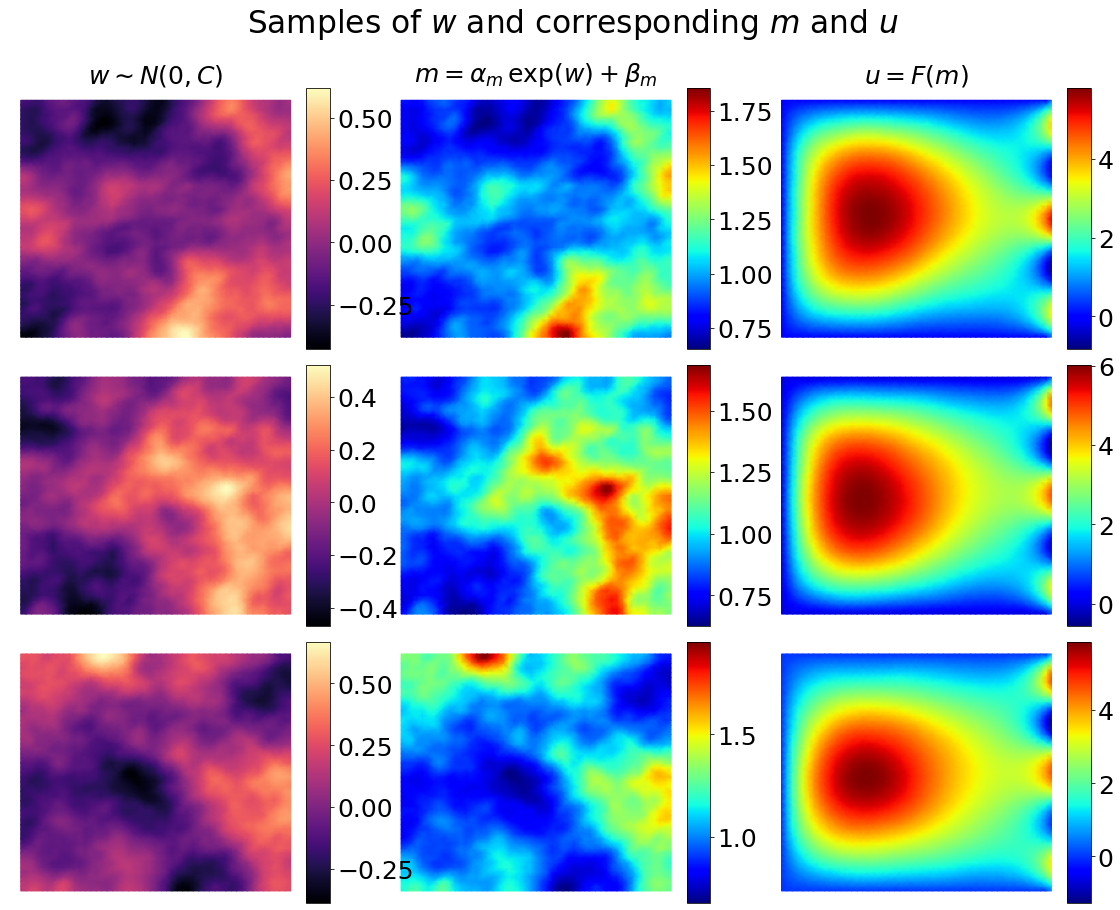

In [10]:
plot_from_data = True
if plot_from_data:
    if generate_data == False:
        data_load = np.load(results_dir + data_prefix + '_samples.npz')
        w_samples = data_load['w_samples']
        m_samples = data_load['m_samples']
        u_samples = data_load['u_samples']
    
    i_choices = np.random.choice(w_samples.shape[0], 3, replace=False)

    n_test_samples = len(i_choices)

    u_vec = []
    title_vec = []
    cmapvec = []
    for i in range(n_test_samples): 
        ii = i_choices[i]
        u_vec.append([w_samples[ii, :], m_samples[ii, :], u_samples[ii, :]])
        cmapvec.append(['magma', 'jet', 'jet'])
        if i == 0:
            title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
        else:
            title_vec.append([None, None, None])

    plot_collection(u_vec, n_test_samples, 3, model.m_nodes, \
             sup_title = r'Samples of $w$ and corresponding $m$ and $u$', \
             title_vec = title_vec, cmapvec = cmapvec, \
             figsize = (16, 12), fs = 25, y_sup_title = 1.05,\
             savefilename = results_dir + data_prefix + '_sample_plots.png')

In [11]:
if True:
    # analyze SVD of the data
    proj_w_dim, proj_m_dim, proj_u_dim = 100, 100, 100
    tol = 1.e-9
    if generate_data is False:
        data = np.load(results_dir + data_prefix + '_samples.npz')
        w_samples = data['w_samples']
        m_samples = data['m_samples']
        u_samples = data['u_samples']
        recompute_svd = True
        if recompute_svd:
            w_mean = np.mean(w_samples, axis = 0)
            m_mean = np.mean(m_samples, axis = 0)
            u_mean = np.mean(u_samples, axis = 0)
            w_std = np.std(w_samples, axis = 0)
            m_std = np.std(m_samples, axis = 0)
            u_std = np.std(u_samples, axis = 0)
            w_normalized = (w_samples - w_mean) / (w_std + tol)
            m_normalized = (m_samples - m_mean) / (m_std + tol)
            u_normalized = (u_samples - u_mean) / (u_std + tol)
            w_SVD, w_s, _ = np.linalg.svd(w_normalized.T, full_matrices = False)
            m_SVD, m_s, _ = np.linalg.svd(m_normalized.T, full_matrices = False)
            u_SVD, u_s, _ = np.linalg.svd(u_normalized.T, full_matrices = False)
        else:
            w_SVD = data['w_SVD']
            m_SVD = data['m_SVD']
            u_SVD = data['u_SVD']
            w_s = data['w_s']
            m_s = data['m_s']
            u_s = data['u_s']
    else:
        w_mean = np.mean(w_samples, axis = 0)
        m_mean = np.mean(m_samples, axis = 0)
        u_mean = np.mean(u_samples, axis = 0)
        w_std = np.std(w_samples, axis = 0)
        m_std = np.std(m_samples, axis = 0)
        u_std = np.std(u_samples, axis = 0)
        w_normalized = (w_samples - w_mean) / (w_std + tol)
        m_normalized = (m_samples - m_mean) / (m_std + tol)
        u_normalized = (u_samples - u_mean) / (u_std + tol)
        w_SVD, w_s, _ = np.linalg.svd(w_normalized.T, full_matrices = False)
        m_SVD, m_s, _ = np.linalg.svd(m_normalized.T, full_matrices = False)
        u_SVD, u_s, _ = np.linalg.svd(u_normalized.T, full_matrices = False)


In [12]:
if True:
    plot_annot_xy = [0.15, 0.35, 0.8, 0.5]
    plot_annot_xy_region = [-5, 300, -0.04, 0.15]
    xy_text_vec = []
    xy_text_vec.append([(-30, 30), (10, 10), (-20, -25)])
    xy_text_vec.append([(-10, 15), (5, -5), (-20, -25)])
    xy_text_vec.append([(-40, 15), (-5, 15), (-20, -25)])
    l_style_vec = [':', (0, (5, 10)), '-', '.']

    plot_s_vec_values([w_s, m_s, u_s], [proj_w_dim, proj_m_dim, proj_u_dim], \
                      ['w', 'm', 'u'], \
                      l_style_vec, \
                      xy_text_vec, \
                      plot_annot_xy, \
                      plot_annot_xy_region, \
                      results_dir + data_prefix + '_svd_analysis_w_m_u')

    xy_text_vec = []
    xy_text_vec.append([(10, 20), (-20, -25)])
    xy_text_vec.append([(5, -5), (-20, -25)])
    xy_text_vec.append([(-20, 15), (-20, -25)])
    l_style_vec = ['-', '-']
    plot_s_vec_values([m_s, u_s], [proj_m_dim, proj_u_dim], \
                      ['m', 'u'], \
                      l_style_vec, \
                      xy_text_vec, \
                      plot_annot_xy, \
                      plot_annot_xy_region, \
                      results_dir + data_prefix + '_svd_analysis_m_u')

OSError: 'seaborn-v0_8-whitegrid' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [ ]:
if generate_data:
    u_mesh_dirichlet_boundary_nodes = get_dirichlet_bc(model.is_point_on_dirichlet_boundary, model.u_nodes)

    # data to save
    np.savez(results_dir + data_prefix + '_samples.npz', \
            w_samples = w_samples, \
            m_samples = m_samples, \
            u_samples = u_samples, \
            num_samples = num_samples, \
            m_dim = model.m_dim, u_dim = model.u_dim, \
            fe_order = fe_order, \
            nx = nx, ny = ny, \
            prior_ac = prior_ac, \
            prior_cc = prior_cc, \
            prior_alpham = prior_logn_scale, \
            prior_betam = prior_logn_translate, \
            u_mesh_nodes = model.u_nodes, \
            m_mesh_nodes = model.m_nodes, \
            u_mesh_elements = model.Vu.mesh().cells(), \
            m_mesh_elements = model.Vm.mesh().cells(), \
            u_mesh_dirichlet_boundary_nodes = u_mesh_dirichlet_boundary_nodes, \
            w_SVD = w_SVD, w_s = w_s, \
            m_SVD = m_SVD, m_s = m_s, \
            u_SVD = u_SVD, u_s = u_s)


    # save mesh 
    ## to read, use the syntax
    ## mesh = dl.Mesh()
    ## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
    ##     infile.read(mesh)
    with dl.XDMFFile(results_dir + data_prefix + '_u_mesh.xdmf') as infile:
        infile.write(model.Vu.mesh())

    with dl.XDMFFile(results_dir + data_prefix + '_m_mesh.xdmf') as infile:
        infile.write(model.Vm.mesh())

In [ ]:
print('m_mesh_nodes shape: {}\nu_mesh_nodes shape: {}\nm_dim: {}\nu_dim: {}'.format(model.m_nodes.shape, model.u_nodes.shape, model.m_dim, model.u_dim))

m_mesh_nodes shape: (2601, 2)
u_mesh_nodes shape: (2601, 2)
m_dim: 2601
u_dim: 2601


## Interpolate function at nodal values to meshgrid for FNO

### Compute and plot interpolation over grid

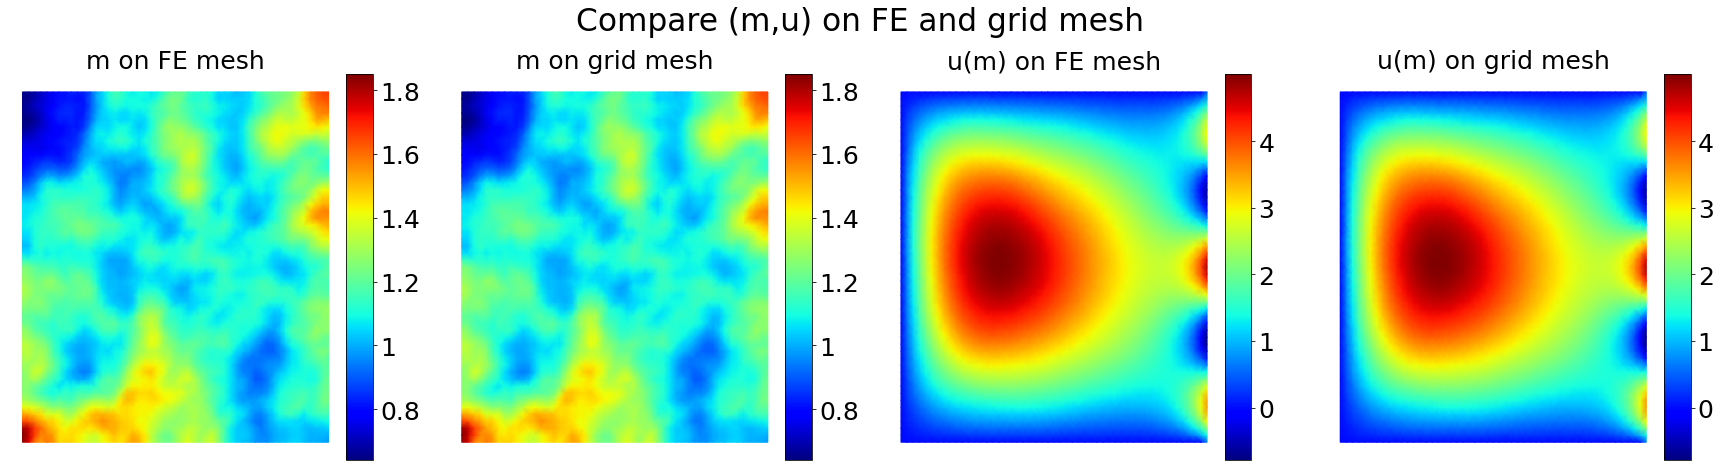

In [14]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')
u_nodes = data_load['u_mesh_nodes']
m_nodes = data_load['m_mesh_nodes']

# get one sample
m = model.samplePrior(transform_m = True)
u = model.solveFwd(u = None, m = m, transform_m = False)

# use interpolation to get data on grid
num_grid_x, num_grid_y = 51, 51
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y), indexing='ij')

# interpolate m and u on grid
grid_m = griddata(m_nodes, m, (grid_x, grid_y), method='linear')
grid_u = griddata(u_nodes, u, (grid_x, grid_y), method='linear')

# plot function on FE mesh and compare with the function on grid

rows = 1
cols = 4
fs = 25
fig, axs = plt.subplots(rows, cols, figsize=(24, 6))

for i in range(cols):
    
    if i%2 == 0:
        # use plotter without element data
        if i == 0:
            cbar = field_plot(axs[i], m, m_nodes, cmap = 'jet')
            axs[i].set_title('m on FE mesh', fontsize = fs)
        else:
            cbar = field_plot(axs[i], u, u_nodes, cmap = 'jet')
            axs[i].set_title('u(m) on FE mesh', fontsize = fs)
    else:
        # use griddata
        if i == 1:
            cbar = field_plot_grid(axs[i], grid_m, grid_x, grid_y, cmap = 'jet')
            axs[i].set_title('m on grid mesh', fontsize = fs)
        else:
            cbar = field_plot_grid(axs[i], grid_u, grid_x, grid_y, cmap = 'jet')
            axs[i].set_title('u(m) on grid mesh', fontsize = fs)

    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='8%', pad=0.03)
    cax.tick_params(labelsize=fs)

    if i < 2:
        # format cbar ticks
        kfmt = lambda x, pos: "{:g}".format(x)
        
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
    else:
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

    axs[i].axis('off')

fig.tight_layout()
fig.suptitle('Compare (m,u) on FE and grid mesh', fontsize=1.25*fs, y=1.075)
fig.savefig(results_dir + data_prefix + '_compare_FE_and_grid_mesh.png',  bbox_inches='tight')
plt.show()


### Interpolate all samples to grid and save to file for FNO

In [15]:
# save all samples to file
generate_fno_data = False
if generate_fno_data:

    num_grid_x, num_grid_y = 51, 51
    print('Generating FNO data for grid sizes ({}, {})'.format(num_grid_x, num_grid_y))

    # get grid coordinates
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y), indexing='ij')

    # load data
    data_load = np.load(results_dir + data_prefix + '_samples.npz')
    
    m_nodes = data_load['m_mesh_nodes']
    u_nodes = data_load['u_mesh_nodes']

    w_samples = data_load['w_samples']
    m_samples = data_load['m_samples']
    u_samples = data_load['u_samples']

    num_samples = m_samples.shape[0]

    # get indices of grid points on the boundary
    u_grid_dirichlet_boundary_nodes = get_grid_dirichlet_bc(model.is_point_on_dirichlet_boundary, grid_x, grid_y)
    
    # interpolate samples on grid
    grid_w_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    for i in range(num_samples):
        start_time = time.perf_counter()
        
        grid_w_samples[i, :, :] = griddata(m_nodes, w_samples[i, :], (grid_x, grid_y), method='linear')
        grid_m_samples[i, :, :] = griddata(m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :] = griddata(u_nodes, u_samples[i, :], (grid_x, grid_y), method='linear')

        # explicity set boundary points to zero (not necessary as the solution of PDE is zero on the boundary)
        grid_u_samples[i, u_grid_dirichlet_boundary_nodes[:,0], u_grid_dirichlet_boundary_nodes[:,1]] = 0.0

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(grid_m_samples.shape, grid_u_samples.shape)

In [16]:
if generate_fno_data:    
    # plot 4 samples randomly chosen from the data
    i_choices = np.random.choice(num_samples, 3, replace=False)

    n_test_samples = len(i_choices)

    u_vec = []
    title_vec = []
    cmapvec = []
    for i in range(n_test_samples): 
        ii = i_choices[i] 
        u_vec.append([grid_w_samples[ii, :, :], grid_m_samples[ii, :, :], grid_u_samples[ii, :, :]])
        cmapvec.append(['magma', 'jet', 'jet'])
        if i == 0:
            title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
        else:
            title_vec.append([None, None, None])

    plot_collection_grid(u_vec, n_test_samples, 3, grid_x, grid_y, \
             sup_title = r'Samples of $w$ and corresponding $m$ and $u$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
             title_vec = title_vec, cmapvec = cmapvec, \
             figsize = (16, 12), fs = 25, y_sup_title = 1.05, \
             savefilename = results_dir + data_prefix + '_sample_plots_on_grid.png')

In [17]:
# data to save
if generate_fno_data:
        np.savez(results_dir + data_prefix + '_FNO_samples.npz', \
                grid_w_samples = grid_w_samples, \
                grid_m_samples = grid_m_samples, \
                grid_u_samples = grid_u_samples, \
                num_samples = num_samples, \
                num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
                grid_x = grid_x, grid_y = grid_y, \
                u_grid_dirichlet_boundary_nodes = u_grid_dirichlet_boundary_nodes)

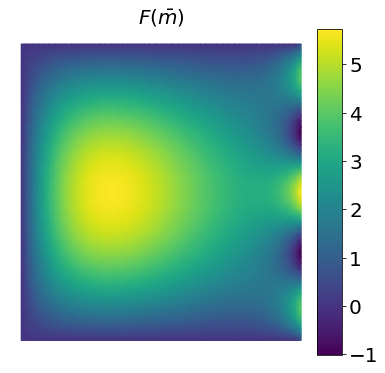

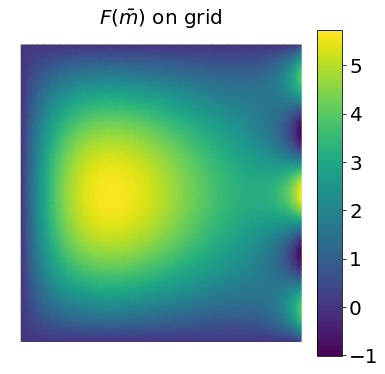

In [18]:
if generate_fno_data is False:
    fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
    grid_u_samples = fno_data_load['grid_u_samples']

u_mean = model.solveFwd(u = None, m = model.m_mean, transform_m = False)
# u_mean = u_samples[0, :]
quick_field_plot(u_mean, model.u_nodes, title=r'$F(\bar{m})$', cmap ='viridis')

grid_u_mean = griddata(u_nodes, u_mean, (grid_x, grid_y), method='linear')
grid_u_mean = grid_u_samples[0, :, :]
quick_field_plot_grid(grid_u_mean, grid_x, grid_y, title=r'$F(\bar{m})$ on grid', cmap ='viridis')

### Load data to test

In [19]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')

print('num_samples: {}\nm_samples shape: {}\nu_samples shape: {}\nm_dim: {}\nu_dim: {}'.format(data_load['num_samples'], data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']))

num_samples: 5000
m_samples shape: (5000, 2601)
u_samples shape: (5000, 2601)
m_dim: 2601
u_dim: 2601


In [20]:
fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
print('num_samples: {}\ngrid_m_samples shape: {}\ngrid_u_samples shape: {}'.format(fno_data_load['num_samples'], fno_data_load['grid_m_samples'].shape, fno_data_load['grid_u_samples'].shape))

num_samples: 5000
grid_m_samples shape: (5000, 51, 51)
grid_u_samples shape: (5000, 51, 51)


# Test setting dirichlet bc on grid

In [21]:
fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
grid_u_samples = fno_data_load['grid_u_samples']
u_grid_dirichlet_boundary_nodes = fno_data_load['u_grid_dirichlet_boundary_nodes']

grid_u_test = grid_u_samples[0, :, :]
grid_u_test_with_bc = grid_u_test.copy()

# change boundary values explicitly
for a in u_grid_dirichlet_boundary_nodes:
    grid_u_test[a[0], a[1]] = 1e+5

# change boundary values in batch
grid_u_test_with_bc[u_grid_dirichlet_boundary_nodes[:,0], u_grid_dirichlet_boundary_nodes[:,1]] = 1e+5

# verify that the boundary values are changed
for a in u_grid_dirichlet_boundary_nodes:
    print('grid_u_test: {}, grid_u_test_with_bc: {}'.format(grid_u_test[a[0], a[1]], grid_u_test_with_bc[a[0], a[1]]))

print('err: {}'.format(np.linalg.norm(grid_u_test.flatten() - grid_u_test_with_bc.flatten())))

grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 100000.0
grid_u_test: 100000.0, grid_u_test_with_bc: 10

In [34]:
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 
indexing='ij')

for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        print('({}, {})'.format(grid_x[i,j], grid_y[i,j]))

(0.0, 0.0)
(0.0, 0.1)
(0.0, 0.2)
(0.0, 0.30000000000000004)
(0.0, 0.4)
(0.0, 0.5)
(0.0, 0.6000000000000001)
(0.0, 0.7000000000000001)
(0.0, 0.8)
(0.0, 0.9)
(0.0, 1.0)
(0.1, 0.0)
(0.1, 0.1)
(0.1, 0.2)
(0.1, 0.30000000000000004)
(0.1, 0.4)
(0.1, 0.5)
(0.1, 0.6000000000000001)
(0.1, 0.7000000000000001)
(0.1, 0.8)
(0.1, 0.9)
(0.1, 1.0)
(0.2, 0.0)
(0.2, 0.1)
(0.2, 0.2)
(0.2, 0.30000000000000004)
(0.2, 0.4)
(0.2, 0.5)
(0.2, 0.6000000000000001)
(0.2, 0.7000000000000001)
(0.2, 0.8)
(0.2, 0.9)
(0.2, 1.0)
(0.30000000000000004, 0.0)
(0.30000000000000004, 0.1)
(0.30000000000000004, 0.2)
(0.30000000000000004, 0.30000000000000004)
(0.30000000000000004, 0.4)
(0.30000000000000004, 0.5)
(0.30000000000000004, 0.6000000000000001)
(0.30000000000000004, 0.7000000000000001)
(0.30000000000000004, 0.8)
(0.30000000000000004, 0.9)
(0.30000000000000004, 1.0)
(0.4, 0.0)
(0.4, 0.1)
(0.4, 0.2)
(0.4, 0.30000000000000004)
(0.4, 0.4)
(0.4, 0.5)
(0.4, 0.6000000000000001)
(0.4, 0.7000000000000001)
(0.4, 0.8)
(0.4, 0.9)


# test interpolation from grid to scatter

(array([[0.  , 0.  ],
        [0.02, 0.  ],
        [0.04, 0.  ],
        ...,
        [0.96, 1.  ],
        [0.98, 1.  ],
        [1.  , 1.  ]]),
 array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
        ...,
        [0.96, 0.96, 0.96, ..., 0.96, 0.96, 0.96],
        [0.98, 0.98, 0.98, ..., 0.98, 0.98, 0.98],
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ]]),
 array([[0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ],
        [0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ],
        [0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ],
        ...,
        [0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ],
        [0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ],
        [0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ]]))

In [37]:
from scipy.interpolate import RegularGridInterpolator

fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')

grid_w_samples = fno_data_load['grid_w_samples']

i_test = np.random.choice(grid_w_samples.shape[0], 1, replace=False)
grid_w_test = grid_w_samples[i_test][0, :, :]
w_test = w_samples[i_test][0, :]

print('grid_w_test shape: {}, w_test shape: {}'.format(grid_w_test.shape, w_test.shape))

interp = RegularGridInterpolator((grid_x[:,0], grid_y[0,:]), grid_w_test)
grid_w_test_interp = interp(m_nodes)

print('grid_w_test_interp shape: {}'.format(grid_w_test_interp.shape))

err = np.linalg.norm(grid_w_test_interp - w_test)
print('err: {}'.format(err))

grid_w_test shape: (51, 51), w_test shape: (2601,)
grid_w_test_interp shape: (2601,)
err: 2.4581786070214252e-15


In [34]:
grid_y[0,:]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [45]:
fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')

grid_w_samples = fno_data_load['grid_w_samples']
grid_x = fno_data_load['grid_x']
grid_y = fno_data_load['grid_y']

num_grid_x = grid_x.shape[0]
num_grid_y = grid_y.shape[1]

num_test = 1

a = grid_w_samples[1:2]
a = a.reshape(num_test, num_grid_x, num_grid_y, 1)


b = np.tile(grid_x, \
            (num_test, 1, 1)\
            ).reshape(num_test, \
                        num_grid_x, \
                        num_grid_y, 1) # exra dim
        
c = np.tile(grid_y, \
            (num_test, 1, 1)\
            ).reshape(num_test, \
                        num_grid_x, \
                        num_grid_y, 1) # exra dim

X = np.concatenate((a, b, c), axis = -1)
print(X.shape)

(1, 51, 51, 3)


TypeError: Cannot interpret '2' as a data type